In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
import ast
import tensorflow as tf
!pip install keras-tuner
!pip install tensorflow_addons
from sklearn.model_selection import RandomizedSearchCV
import tensorflow_addons as tfa
import pickle
#from tensorflow.keras import mixed_precision
import keras_tuner as kt
from xgboost import XGBClassifier
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)
keras.utils.set_random_seed(9)
drive.mount('/content/drive')

     |████████████████████████████████| 133 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
Mounted at /content/drive


In [2]:
model = keras.models.load_model('/content/drive/MyDrive/data_490/final_model')

In [3]:
injury_history = pd.read_csv('/content/drive/MyDrive/data_490/injury_data/injury_history')
bio_data = pd.read_csv('/content/drive/MyDrive/data_490/processed_data/bio_data.csv')
ts_data = pd.read_pickle('/content/drive/MyDrive/data_490/processed_data/thirty_day_timestep_df')
bio_data.player_age = bio_data['player_age'].str.split(' ').str[0]

In [4]:
##Does not include dense layer, outputs normalized bio data, normalized injury history, and encoder outpout of the time series data
base_model = keras.Model(inputs=model.input, outputs=model.layers[-10].output)

In [5]:
train_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/train_indexes.csv')
valid_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/valid_indexes.csv')
test_indexes = np.loadtxt('/content/drive/MyDrive/data_490/processed_data/test_indexes.csv')
bio_data = bio_data.fillna(-1)
injury_history = injury_history.fillna(-1)
#Leaves off the simple absolute positional encoding of the time series data
ts_train = np.stack(ts_data.loc[train_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
ts_valid = np.stack(ts_data.loc[valid_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
ts_test = np.stack(ts_data.loc[test_indexes, 'time_series'].values).astype(np.float16)[:,:,:-1]
bio_train = bio_data.iloc[train_indexes, 2:].astype(np.float16)
bio_valid = bio_data.iloc[valid_indexes, 2:].astype(np.float16)
bio_test = bio_data.iloc[test_indexes, 2:].astype(np.float16)
injury_train = injury_history.iloc[train_indexes, 2:].astype(np.float16)
injury_valid = injury_history.iloc[valid_indexes, 2:].astype(np.float16)
injury_test = injury_history.iloc[test_indexes, 2:].astype(np.float16)
train_target =  ts_data.loc[train_indexes, 'injured'].astype(np.float16)
valid_target =  ts_data.loc[valid_indexes, 'injured'].astype(np.float16)
test_target = ts_data.loc[test_indexes, 'injured'].astype(np.float16)

In [6]:
test_output = base_model.predict([ts_test, injury_test, bio_test])
valid_output = base_model.predict([ts_valid, injury_valid, bio_valid])
train_output = base_model.predict([ts_train, injury_train, bio_train])

In [7]:
params = pd.read_csv('/content/drive/MyDrive/data_490/xgb_head_search_results.csv')
params = params.sort_values('rank_test_score',  ascending=True).loc[0,'params']

In [8]:
ast.literal_eval(params)

{'colsample_bylevel': 0.4,
 'colsample_bytree': 0.7,
 'eg_lambda': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 5000,
 'reg_alpha': 0.05,
 'subsample': 0.7}

In [9]:
head = XGBClassifier(n_estimators=5000, sub_sample=.9, colsample_bytree=.9)
head.fit(train_output, train_target,verbose=True, eval_set=[(valid_output, valid_target)], early_stopping_rounds=100)

[0]	validation_0-error:0.016918
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.015973
[2]	validation_0-error:0.017485
[3]	validation_0-error:0.015878
[4]	validation_0-error:0.017485
[5]	validation_0-error:0.016918
[6]	validation_0-error:0.015973
[7]	validation_0-error:0.016918
[8]	validation_0-error:0.016918
[9]	validation_0-error:0.016918
[10]	validation_0-error:0.017485
[11]	validation_0-error:0.016918
[12]	validation_0-error:0.017485
[13]	validation_0-error:0.016918
[14]	validation_0-error:0.017107
[15]	validation_0-error:0.017485
[16]	validation_0-error:0.017485
[17]	validation_0-error:0.016776
[18]	validation_0-error:0.017485
[19]	validation_0-error:0.017485
[20]	validation_0-error:0.017485
[21]	validation_0-error:0.017485
[22]	validation_0-error:0.017485
[23]	validation_0-error:0.017485
[24]	validation_0-error:0.017485
[25]	validation_0-error:0.017485
[26]	validation_0-error:0.01739
[27]	validation_0-error:0.017485
[28]	validation_0-er

XGBClassifier(colsample_bytree=0.9, n_estimators=5000, sub_sample=0.9)

In [15]:
train_pred = head.predict_proba(train_output)[:,1]
train_injury_rate = np.mean(train_target)*100
high_risk_cutoff = np.percentile(train_pred, 100 - train_injury_rate)
print(high_risk_cutoff)

0.11259540241724153


In [20]:
test_pred = head.predict_proba(test_output)[:,1]
test_high_risk = np.where(test_pred > high_risk_cutoff)
test_normal_risk = np.where(test_pred < high_risk_cutoff)
test_low_risk = np.where(test_pred < np.percentile(train_pred, 50))
print(f'high risk injury rate: {np.mean(test_target.iloc[test_high_risk[0]])}')
print(f'normal risk injury rate: {np.mean(test_target.iloc[test_normal_risk[0]])}')
print(f'low risk injury rate: {np.mean(test_target.iloc[test_low_risk[0]])}')

high risk injury rate: 0.65673828125
normal risk injury rate: 0.0072174072265625
low risk injury rate: 0.00159454345703125


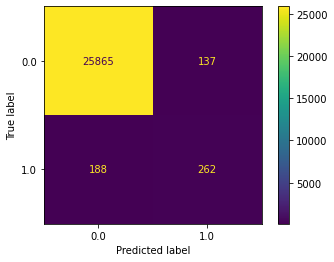

In [22]:
predictions = np.zeros(len(test_target), dtype=int)
predictions[test_high_risk[0]] = 1
metrics.ConfusionMatrixDisplay.from_predictions(test_target, predictions)

In [25]:
print(metrics.recall_score(test_target, predictions))
print(metrics.precision_score(test_target, predictions))
metrics.f1_score(test_target, predictions)

0.5822222222222222
0.656641604010025


0.6171967020023557

In [26]:
head.save_model('/content/drive/MyDrive/data_490/xgb_head.json')